# SOLUCIÓN PROYECTO PT 1
Por: *Katerine Arias*

La solución de este proyecto se desarrolla en siete etapas:

1. Exploración y perfilamiento del conjunto de datos.
2. Limpieza y preparación del conjunto de datos.
3. Modelo de regresión polinomial.
4. Modelo de regresión Lasso.
5. Rendimiento de los modelos.
6. Interpretabilidad modelo Lasso.
7. Análisis de resultados

Como en cualquier problema de machine learning, el primer paso es analizar el problema. En esta primera etapa del proyecto, el objetivo es desarrollar un modelo predictivo utilizando técnicas de regresión para estimar la demanda de un sistema de alquiler de bicicletas. Además, se busca que el modelo sea interpretable, permitiendo comprender los factores que influyen en la predicción.


## 1. Exploración y perfilamiento del conjunto de datos

En primer lugar, se importan las librerías necesarias para el desarrollo del proyecto.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from ydata_profiling import ProfileReport
from IPython import display
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Se revisa la versión de las librerías
from importlib.metadata import version

print(f"Versión de Pandas: {version('pandas')}")
print(f"Versión de Matplotlib: {version('matplotlib')}")
print(f"Versión de Seaborn: {version('seaborn')}")
print(f"Versión de Scikit-learn: {version('scikit-learn')}")
print(f"Versión de Numpy: {version('numpy')}")

Versión de Pandas: 2.2.2
Versión de Matplotlib: 3.9.2
Versión de Seaborn: 0.13.2
Versión de Scikit-learn: 1.5.1
Versión de Numpy: 1.26.4


Se procede a cargar el conjunto de datos del problema. Además, se cargará el diccionario de datos, una herramienta clave para comprender los rangos y significados de las variables.

In [36]:
#Ruta del archivo
path_data = 'data/datos_etapa1_csv.csv'

#Se carga dataframe
data_raw = pd.read_csv(path_data, index_col=None)

#Se imprimen las primeras filas
data_raw.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


El diccionario está dado por:

In [37]:
#Ruta del archivo
path_dict = 'data/dict_etapa1.xlsx'

#Se carga dataframe
dict_file = pd.read_excel(path_dict)

#Se imprime el diccionario
dict_file.head(10)

,Columna,Tipo,Descripción
0,season,categórica,"Estación del año (Winter, Spring, Summer, Fall)"
1,weekday,numérico,Día de la semana (de 1 a 7)
2,weathersit,categórica,"Clima (Clear, Mist, Light Rain, Heavy Rain)"
3,temp,numérico,Temperatura
4,atemp,numérico,Sensación de temperatura
5,hum,numérico,Humedad
6,windspeed,numérico,Velocidad del viento
7,cnt,numérico,Cantidad de bicicletas rentadas
8,time_of_day,categórica,"Parte del día (Morning, Evening, Night)"


El conjunto de datos está compuesto por un total de 17379 instancias y presenta 9 variables en total, de las cuales 8 son predictoras y 1 corresponde a la variable objetivo (target).

In [38]:
data_raw.shape

(17379, 9)

Se procede a confirmar que el tipo de datos del conjunto sea como se establece en el diccionario. El tipo de dato *object* corresponde a datos categóricos, mientras que *float64* e *int64* corresponden a datos numéricos.

In [39]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17379 non-null  object 
 1   weekday      17379 non-null  int64  
 2   weathersit   17379 non-null  object 
 3   temp         17379 non-null  float64
 4   atemp        17379 non-null  float64
 5   hum          17379 non-null  float64
 6   windspeed    17379 non-null  float64
 7   cnt          17379 non-null  int64  
 8   time_of_day  17379 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.2+ MB


En este punto, es importante destacar que la variable `weekday` se está interpretando como numérica. Sin embargo, aunque su formato sea numérico, en realidad es una variable categórica, ya que representa los días de la semana. Por ello, se realizará un ajuste para convertirla en una cadena de texto, manteniendo su formato numérico, pero asegurando que sea tratada correctamente como una categoría en el análisis.

In [40]:
#Se conviert weekday a string
data_raw["weekday"] = data_raw["weekday"].astype(str)

Se utiliza la biblioteca `ydata-profiling` para generar un informe exploratorio automatizado del dataset. De esta forma, es posible proporcionar estadísticas descriptivas, detección de valores atípicos, correlaciones entre variables y una visión general de la calidad de los datos. 

In [41]:
profile = ProfileReport(data_raw, explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Dado que el diccionario de datos no proporciona información sobre los rangos de las variables, se combinará el "conocimiento del contexto" con el criterio de Tukey para identificar límites razonables en sus valores.

Antes de proceder con la limpieza y preparación de los datos, es fundamental detectar posibles valores atípicos (outliers). Identificar estas anomalías permite comprender mejor la distribución de los datos, corregir errores, y tomar decisiones fundamentadas sobre su tratamiento, ya sea eliminándolos, ajustándolos o conservándolos según el contexto del análisis.

Por esta razón, se aplicará el criterio de Tukey, una metodología estadística ampliamente utilizada para identificar outliers con base en los cuartiles y el rango intercuartílico.

Tukey usa el primer cuartil `Q1` y el tercerl cuartil `Q3`. Posteriormente, se obtiene el rango intercuartílico (IQR) como:
$$
IQR = Q_{3} - Q_{1}
$$

Los límites quedan definidos como:
$$
L_{i} = Q_{1} - 1.5 \times IQR
$$
$$
L_{s} = Q_{3} + 1.5 \times IQR
$$

Por lo tanto, todos los valores por fuera de estos rangos se consideran `outliers`

In [42]:
#Se define la función que calcula el criterio de Tukey para las variables numéricas
def criterio_tukey(columna):
    """
    Calcula los valores atípicos usando el criterio de Tukey.
    
    Parámetros:
        columna (list o np.array): Lista o array con los datos numéricos.
    
    Retorna:
        str: Mensaje con los rangos superior e inferior y la cantidad de outliers.
    """
    Q1 = np.percentile(columna, 25)
    Q3 = np.percentile(columna, 75)
    IQR = Q3 - Q1
    
    rango_inferior = Q1 - 1.5 * IQR
    rango_superior = Q3 + 1.5 * IQR
    
    outliers = [x for x in columna if x < rango_inferior or x > rango_superior]
    cantidad_outliers = len(outliers)
    
    return (f"Rango inferior: {rango_inferior:.2f}\n"
            f"Rango superior: {rango_superior:.2f}\n"
            f"Cantidad de outliers: {cantidad_outliers}")

#Se aplica el criterio para las variables numéricas
print(" --- Variable : temp --- ")
print(criterio_tukey(data_raw['temp']))
print(" --- Variable : atemp --- ")
print(criterio_tukey(data_raw['atemp']))
print(" --- Variable : hum --- ")
print(criterio_tukey(data_raw['hum']))
print(" --- Variable : windspeed --- ")
print(criterio_tukey(data_raw['windspeed']))
print(" --- Variable : cnt --- ")
print(criterio_tukey(data_raw['cnt']))

 --- Variable : temp --- 
Rango inferior: -14.58
Rango superior: 45.58
Cantidad de outliers: 0
 --- Variable : atemp --- 
Rango inferior: -22.50
Rango superior: 53.50
Cantidad de outliers: 0
 --- Variable : hum --- 
Rango inferior: 0.03
Rango superior: 1.23
Cantidad de outliers: 22
 --- Variable : windspeed --- 
Rango inferior: -7.99
Rango superior: 31.99
Cantidad de outliers: 342
 --- Variable : cnt --- 
Rango inferior: -321.50
Rango superior: 642.50
Cantidad de outliers: 505


Por otro lado, es fundamental comprender el comportamiento de las variables categóricas en relación con la variable objetivo. Esto permitirá obtener una mejor perspectiva sobre cómo procesarlas y transformarlas adecuadamente en etapas posteriores. Por ello, se elaborará un diagrama de barras para su análisis.

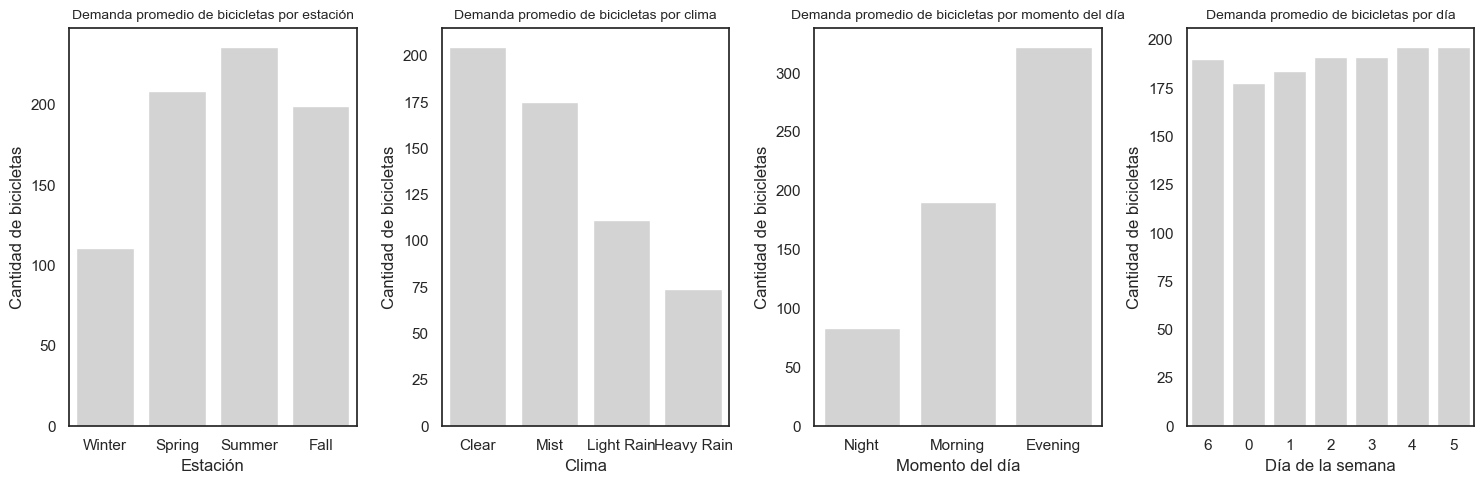

In [43]:
%matplotlib inline

# Configuración de estilo
sns.set(style="white")

# Crear una figura con tres subgráficos
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

#Color de la barra
bar_color = "lightgray"

# Gráfico de barras para la demanda por estación (season)
sns.barplot(x="season", y="cnt", data=data_raw, errorbar=None, color=bar_color, ax = axes[0])
axes[0].set_title("Demanda promedio de bicicletas por estación", fontsize=10)
axes[0].set_xlabel("Estación")
axes[0].set_ylabel("Cantidad de bicicletas")
axes[0].grid(False)

# Gráfico de barras para la demanda según el clima (weathersit)
sns.barplot(x="weathersit", y="cnt", data=data_raw, errorbar=None, color=bar_color, ax = axes[1])
axes[1].set_title("Demanda promedio de bicicletas por clima", fontsize=10)
axes[1].set_xlabel("Clima")
axes[1].set_ylabel("Cantidad de bicicletas")
axes[1].grid(False)

# Gráfico de barras para la demanda por momento del día (time_of_day)
sns.barplot(x="time_of_day", y="cnt", data=data_raw, errorbar=None, color=bar_color, ax = axes[2])
axes[2].set_title("Demanda promedio de bicicletas por momento del día", fontsize=10)
axes[2].set_xlabel("Momento del día")
axes[2].set_ylabel("Cantidad de bicicletas")
axes[2].grid(False)

# Gráfico de barras para la demanda por día de la semana (weekday)
sns.barplot(x="weekday", y="cnt", data=data_raw, color=bar_color, errorbar=None, ax = axes[3])
axes[3].set_title("Demanda promedio de bicicletas por día", fontsize=10)
axes[3].set_xlabel("Día de la semana")
axes[3].set_ylabel("Cantidad de bicicletas")
axes[3].grid(False)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

**Conclusiones del EDA (Análisis Exploratorio de datos):**
- El dataset no presenta *missing values*.
- Se identificaron 41 filas duplicadas (0.2% del total), lo que, aunque no representa una cantidad elevada, podría generar redundancias y sesgos en el análisis. Se eliminarán en la etapa de preparación y liempieza de datos.
- Se observó una fuerte correlación entre las variables `temp` y `atemp`, lo que podría representar un problema de multicolinealidad en modelos predictivos, afectando la estabilidad de los coeficientes y la interpretabilidad de los resultados. Sin embargo, en el contexto del problema analizado, esta correlación podría resultar lógica y esperada, ya que la temperatura y la sensación térmica suelen estar estrechamente vinculadas. Aún así, podría evaluarse el impacto de esta relación en los modelos mediante técnicas de selección como regresión regularizada Lasso.
- Se identificó que la variable `windspeed` contiene un alto porcentaje de valores cero (12.5%). En el caso de `windspeed`, es razonable que algunos valores sean cero, lo que indica ausencia de viento.
- En la variable `weekday`, el diccionario indica que sus valores deberían estar entre 1 y 7. Sin embargo, en el dataset se encuentran valores entre 0 y 6, lo que sugiere un posible error en la codificación de los datos. No obstante, dado que se trata de una variable categórica, su rango numérico no afectará el análisis, ya que será transformada en una variable dummy.
- Según el análisis basado en el criterio de Tukey, la variable `hum`, que representa la humedad, presenta 22 valores atípicos. De acuerdo con el Análisis Exploratorio de Datos (EDA), estos registros tienen un valor de 0. Desde una perspectiva meteorológica, una humedad del 0% no es un valor posible, lo que sugiere que estos datos son erróneos o inconsistentes. Además, estos registros representan solo el 0.1% del conjunto de datos, por lo que su eliminación no afectará significativamente el análisis. Por esta razón, se procederá a eliminarlos.
- Las variables `weathersit`, `season`, `weekday` y `time_of_day` se  tratarán como variables categóricas *nominales*.
- A pesar de que el criterio de Tukey identifica outliers en la velocidad del viento (variable `windspeed`) con valores inferiores a -7.99, desde el punto de vista del dominio del problema, no es posible que la velocidad del viento tenga valores negativos. Sin embargo, en el conjunto de datos existen registros con un valor de 0, los cuales se encuentran dentro de los límites normales según el criterio de Tukey y, además, tienen sentido en el contexto del problema. Por esta razón, dichos valores de 0 no serán eliminados. Además, si se llegaran a eliminar todos los valores identificados como outliers, esto afectaría significativamente el tamaño del conjunto de datos, ya que representan el 12.5% del total.
- En cuanto a la variable `cnt`, el criterio de Tukey establece un límite superior de 642.50 para considerar valores como outliers, lo que resultaría en 505 registros marcados como atípicos. No obstante, en el contexto del problema, no existe un límite máximo para la demanda de alquiler de bicicletas. Por esta razón, estos valores no serán eliminados.

## 2. Limpieza y preparación del conjunto de datos

En esta etapa se harán las transformaciones necesarias para convertir el dataset a una forma en la que los algoritmos puedan interpretarlo de manera eficiente. Teniendo en cuenta las conclusiones del análisis exploratorio, se aplicarán técnicas de limpieza de datos, eliminación de duplicados, codificación de variables categóricas y escalado de variables numéricas según sea necesario.

Adicionalmente, se partirá el conjunto de datos en entrenamiento y test utilizando la función `train_test_split`, con un `random_state` de 77 para asegurar la reproducibilidad de los resultados. 

Antes de manipular el dataset, se hará una copia de los datos en bruto. 

In [44]:
data = data_raw.copy()
data.head()
#print(id(data))

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


### 2.1. Eliminación de valores duplicados

In [45]:
data.drop_duplicates(keep='first',inplace = True, ignore_index = False)
data.shape
#print(id(data))

(17337, 9)

Ahora el dataset tiene valores unicos.

In [46]:
data.duplicated().sum()
#data.describe()
#print(id(data))

0

Dado que existe una fuerte correlación entre `temp` y `atemp`, no se eliminará ninguna de estas variables en esta etapa. En su lugar, se opta por utilizar una regresión regularizada Lasso, la cual permitirá evaluar la importancia relativa de cada variable y, en caso necesario, realizar una selección automática de características.

### 2.2 Eliminación de outliers en la variable *hum*

Dado que los 22 valores atípicos de esta variable representan solo el 0.1% del conjunto de datos, su eliminación no supone una pérdida significativa de información ni afecta de manera relevante el análisis.

In [47]:
data = data[data['hum'] != 0]
data.describe()
#print(id(data))

,temp,atemp,hum,windspeed,cnt
count,17315.000000,17315.000000,17315.000000,17315.000000,17315.000000
mean,15.380186,15.427068,0.627721,12.738452,190.071094
std,9.050500,11.343584,0.191679,8.196873,181.421584
min,-7.060000,-16.000000,0.080000,0.000000,1.000000
25%,7.980000,5.997800,0.480000,7.001500,41.000000
50%,15.500000,15.996800,0.630000,12.998000,143.000000
75%,23.020000,24.999200,0.780000,16.997900,281.000000
max,39.000000,50.000000,1.000000,56.996900,977.000000


### 2.3. Partición del conjunto de datos

Se realiza la partición del conjunto de datos en entrenamiento y test, asegurando la reproducibilidad mediante la configuración de `random_state = 77`. La división será: 80% entrenamiento y 20% test.

In [48]:
#Se separa la variable objetivo de las variables predictoras
x = data.drop(["cnt"], axis = 1)
y = data["cnt"]

#Conjunto de datos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=77)

### 2.4. Transformación en el conjunto de entrenamiento

Dado que el conjunto de datos contiene variables que requieren diferentes tipos de transformaciones, el primer paso será aplicar `RobustScaler()` para reducir la influencia de valores atípicos en las variables numéricas. Posteriormente, se convertirán las variables categóricas mediante `OneHotEncoder()`para representar sus valores de forma binaria y facilitar su uso en los posteriores modelos.

In [49]:
# Nombre de variables numéricas y categóricas
numeric_columns =  ['temp', 'atemp', 'hum', 'windspeed']
categoric_columns = ['weekday','season', 'weathersit', 'time_of_day']

# Genera una copia de los valores de entrenamiento
x_train_copy = x_train.copy()

# ---- Transformación de variables numéricas ----
scaler = RobustScaler()
x_train_scaler= scaler.fit_transform(x_train_copy[numeric_columns])
scaler_train_df = pd.DataFrame(x_train_scaler, columns=scaler.get_feature_names_out(numeric_columns))
##scaler_train_df.head()

# ---- Transformación de variables categóricas ----
encoder = OneHotEncoder(sparse_output = False)
x_train_ohe = encoder.fit_transform(x_train_copy[categoric_columns])
ohe_train_df = pd.DataFrame(x_train_ohe, columns=encoder.get_feature_names_out(categoric_columns))
##ohe_train_df.head()

# Resetear índices
scaler_train_df.reset_index(drop=True, inplace=True)
ohe_train_df.reset_index(drop=True, inplace=True)

# Concatenar los DataFrames transformados
x_train_final = pd.concat([scaler_train_df, ohe_train_df], axis=1)
x_train_final.head()

,temp,atemp,hum,windspeed,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,season_Spring,season_Summer,season_Winter,weathersit_Clear,weathersit_Heavy Rain,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,0.7500,0.579020,-0.838710,-0.400134,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.3125,0.316082,0.483871,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.6250,-0.631469,0.225806,-0.400134,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.3750,-0.315735,-0.645161,0.200402,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.1250,-1.157694,-0.548387,-0.199732,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# 3. Modelo de regresión polinomial

Tras transformar los datos de manera básica para su uso en modelos posteriores, se construirá un modelo de regresión polinomial. Para ello, se utilizará un `make_pipeline` que incluirá la transformación de `PolynomialFeatures` (aplicada a todo el conjunto de datos) y, posteriomente, `LinearRegression`.

A continuación, se definirá un diccionario que establecerá el espacio de búsqueda de hiperparámetros, almacenando estos valores en la variable `param_grid_polynomial` mediante el parámetro `polynomialfeatures__degree`. La búsqueda se limitará a polinomios de grado 2 y 3.

Posteriormente, se creará un objeto de la clase `KFold` para obtener una estimación más realista del desempeño del modelo, evitando depender únicamente del conjunto de test.

Luego, se implementará `GridSearchCV` para llevar a cabo una búsqueda exhaustiva de los mejores hiperparámetros. Finalmente, se entrenarán los modelos utilizando el método `fit()` con los conjuntos de entrenamiento.

In [50]:
# make_pipeline con la transformación de PolynomialFeatures y luego el modelo de regresión lineal 
polynomial_regression = make_pipeline(
    PolynomialFeatures(),
    LinearRegression()
)

#Diccionario para establecer espacio de busqueda
param_grid_polynomial = {'polynomialfeatures__degree': [2, 3]}

# Técnica de selección de modelos
kfold_polynomial = KFold(n_splits=10, shuffle=True, random_state=0)

#Modelos
models_grid_polynomial = GridSearchCV(polynomial_regression, param_grid_polynomial, cv=kfold_polynomial, n_jobs=-1)

In [51]:
%%time
#Entrenamiento de los  modelos 
models_grid_polynomial.fit(x_train_final, y_train)
print("Mejor parámetro: ", models_grid_polynomial.best_params_)

Mejor parámetro:  {'polynomialfeatures__degree': 3}
CPU times: total: 37 s
Wall time: 1min 32s


Se obtiene el mejor modelo guardandolo en la variable `best_polynomial_model`

In [52]:
best_polynomial_model = models_grid_polynomial.best_estimator_
best_polynomial_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

## 3.1. Transformación de datos de test

Dado que antes de generar el `make_pipeline` para el modelo de regresión polinomial se aplicaron transformaciones manuales a los datos de entrenamiento, es necesario realizar las mismas transformaciones de forma manual en los datos de prueba utilizando los trandformadores generados en los datos de entrenamiento.

In [53]:
# Genera una copia de los valores de test
x_test_copy = x_test.copy()

# ---- Transformación de variables numéricas ----
x_test_scaler= scaler.transform(x_test_copy[numeric_columns])
scaler_test_df = pd.DataFrame(x_test_scaler, columns=scaler.get_feature_names_out(numeric_columns))
##scaler_test_df.head()

# ---- Transformación de variables categóricas ----
x_test_ohe = encoder.transform(x_test_copy[categoric_columns])
ohe_test_df = pd.DataFrame(x_test_ohe, columns=encoder.get_feature_names_out(categoric_columns))
##ohe_train_df.head()

# Resetear índices
scaler_test_df.reset_index(drop=True, inplace=True)
ohe_test_df.reset_index(drop=True, inplace=True)

# Concatenar los DataFrames transformados
x_test_final = pd.concat([scaler_test_df, ohe_test_df], axis=1)
x_test_final.head()

,temp,atemp,hum,windspeed,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,season_Spring,season_Summer,season_Winter,weathersit_Clear,weathersit_Heavy Rain,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,-0.9375,-0.947204,0.193548,-0.400134,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.6250,0.579020,-0.387097,-1.300268,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.9375,0.947551,-0.258065,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0000,1.000000,-0.451613,-0.599866,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.1875,-0.157694,-0.032258,-0.599866,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## 3.2. Evaluación del modelo de regresión polinomial

In [54]:
y_pred_polynomial = best_polynomial_model.predict(x_test_final)

print(f'------ Mejor modelo de regresión polinomial (TEST)----')
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_polynomial):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_polynomial):.2f}")
print(f'R²: {r2_score(y_test, y_pred_polynomial):.2f}')

------ Mejor modelo de regresión polinomial (TEST)----
RMSE: 129.84
MAE: 94.87
R²: 0.50


# 4. Modelo de regresión Lasso

Tras transformar los datos de manera básica, se generará ahora un modelo de regresión Lasso. Para ello, se utilizará la función `Lasso()` que incluirá como parámetro el número de iteraciones el cual será fijado a 2000.

A continuación, se definirá un diccionario que establecerá el espacio de búsqueda de hiperparámetros, almacenando estos valores en la variable `param_grid_lasso` mediante el parámetro `alpha`. La búsqueda se limitará a valores de `alpha` de [1,2,3,4,5].

Posteriormente, se creará un objeto de la clase `KFold` para obtener una estimación más realista del desempeño del modelo, evitando depender únicamente del conjunto de test.

Luego, se implementará `GridSearchCV` para llevar a cabo una búsqueda exhaustiva de los mejores hiperparámetros. Finalmente, se entrenarán los modelos utilizando el método `fit()` con los conjuntos de entrenamiento.

In [55]:
#Función de lasso
lasso = Lasso(max_iter=2000)

#Diccionario para establecer espacio de busqueda
param_grid_lasso = {'alpha': [1, 2, 3, 4, 5]}

# Técnica de selección de modelos
kfold_lasso = KFold(n_splits=10, shuffle=True, random_state=0)

#Modelos
models_grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=kfold_lasso, n_jobs=-1)

In [56]:
%%time
#Entrenamiento de los  modelos 
models_grid_lasso.fit(x_train_final, y_train)
print("Mejor parámetro: ", models_grid_lasso.best_params_)

Mejor parámetro:  {'alpha': 1}
CPU times: total: 672 ms
Wall time: 1.73 s


Se obtiene el mejor modelo guardándolo en la variable `best_lasso_model`

In [57]:
best_lasso_model = models_grid_lasso.best_estimator_
best_lasso_model

Lasso(alpha=1, max_iter=2000)

## 4.1. Evaluación del modelo de regresión Lasso

In [58]:
y_pred_lasso = best_lasso_model.predict(x_test_final)

print(f'------ Mejor modelo de regresión Lasso (TEST)----')
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_lasso):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso):.2f}")
print(f'R²: {r2_score(y_test, y_pred_lasso):.2f}')

------ Mejor modelo de regresión Lasso (TEST)----
RMSE: 137.43
MAE: 101.59
R²: 0.44


# 5. Rendimiento de los modelos

Se elaborará una tabla comparativa con los mejores modelos de regresión polinómica y Lasso, evaluando su desempeño mediante las métricas $R^{2}$, RMSE y MAE.

In [59]:
metricas_comparacion = pd.DataFrame(
    {
        "Métrica" : ["RMSE","MAE","R2"],
        "R. Polinómica [grado 3]" : [root_mean_squared_error(y_test, y_pred_polynomial), mean_absolute_error(y_test, y_pred_polynomial),r2_score(y_test, y_pred_polynomial)],
        "R. Lasso [alpha 1]" : [root_mean_squared_error(y_test, y_pred_lasso), mean_absolute_error(y_test, y_pred_lasso),r2_score(y_test, y_pred_lasso)]
    }
)
metricas_comparacion.head()

,Métrica,R. Polinómica [grado 3],R. Lasso [alpha 1]
0,RMSE,129.838576,137.427596
1,MAE,94.865110,101.591869
2,R2,0.497371,0.436897


# 6. Interpretabilidad modelo Lasso

La regresión Lasso, además de ser una técnica de regularización que limita el espacio de hipótesis del modelo final, también permite evaluar la relevancia de las variables en el modelo. A partir de la siguiente tabla de coeficientes, se pueden extraer las siguientes conclusiones:

1. La variable `windspeed` (velocidad del viento) no tiene impacto en el modelo, ya que su coeficiente es exactamente cero.
2. La variable `hum` (humedad) tiene un impacto significativo en la variable objetivo, aunque su relación es negativa.
3. Las variables `temp` (temperatura) y `atemp` (sensación térmica) tienen una fuerte relación positiva con la variable objetivo. Adicionalmente, los coeficiente de estas variables son muy similares.
4. La variable `weathersit` (clima) parece estar sobredimensionada en términos de cardinalidad. Solo una de sus categorías (`weathersit_Light Rain`) tiene una contribución relevante al modelo, lo que sugiere que podría ser conveniente reducir la cardinalidad y agruparla en categorías más generales, como "lluvia" o "sin lluvia".
5. Dado que los coeficientes de los días de la semana (`weekday_0` a `weekday_6`) son cercanos a cero, una mejor estrategia podría ser reemplazar estas variables por una única variable binaria que indique si el día corresponde a un fin de semana o a un día hábil. De esta manera, se reduciría la dimensionalidad del modelo. Además, esta nueva variable podría capturar posibles diferencias en patrones de comportamiento entre los días de semana y los fines de semana, lo que podría resultar más relevante para la predicción.
6. La variable categórica `season` influye significativamente en el modelo con todos sus valores, por lo que reducir su cardinalidad no sería apropiado.

In [60]:
pd.DataFrame(zip(x_train_final.columns, best_lasso_model.coef_),columns=["Variable","Coeficiente"])

,Variable,Coeficiente
0,temp,49.862869
1,atemp,49.737993
2,hum,-47.049258
3,windspeed,0.000000
4,weekday_0,-1.630683
5,weekday_1,-0.000000
6,weekday_2,-0.000000
7,weekday_3,0.000000
8,weekday_4,0.000000
9,weekday_5,0.000000


# 7. Análisis de resultados

**¿Cuál es el grado de la transformación polinomial que fue seleccionado utilizando la técnica de validación?**

El grado óptimo de la transformación polinomial, determinado mediante la técnica de validación, fue 3. Este resultado se obtuvo después de aplicar un transformador `RobustScaler`, lo que sugiere que un modelo de tercer grado proporciona el mejor desempeño en términos de ajuste y generalización.

**¿Cuál fue el valor de α que fue seleccionado utilizando la técnica de validación para la regresión Lasso?**

El valor de α determinado mediante la técnica de validación para la regresión Lasso fue 1.

**¿Cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?**

El mejor modelo según las métricas de rendimiento es la regresión polinómica grado 3. 

La regresión polinómica alcanza un 0.50, mientras que la regresión Lasso obtiene 0.44. Un R² más alto indica que el modelo polinómico explica mejor la variabilidad de los datos. Por otra parte, la regresión polinómica también presenta un menor MAE en comparación con la regresión Lasso, lo que sugiere que el promedio de las diferencias entre los valores reales y los predichos es menor en la regresión polinómica. Por último, el RMSE es menor en la regresión polinómica.

**¿Cuáles variables fueron seleccionadas con el modelo Lasso? A partir de estas, ¿qué interpretación de cara al problema puedes dar?  Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema**

Las variables seleccionadas son aquellas cuyo valor de coeficiente es diferente a cero:

- El valor de "0" en `weekday`
- `temp`
- `atemp`
- `hum`
- Todas las categorías de `season`
- El valor Light Rain de la variable `weathersit`
- Los valores Evening y Night de `time_of_day`

La interpretación de los coeficientes es:

- La temperatura y la sensación térmica son factores influyentes y tienen un impacto positivo, lo que indica que a mayor temperatura, la variable objetivo aumenta.
- La humedad impacta negativamente, lo que sugiere que un aumento en la humedad reduce la demanda sobre el sistema de alquiler de bicicletas. Esto es consistente con la idea de que en días muy húmedos, la actividad al aire libre disminuye.
- Las estaciones afectan la demanda, con otoño y primavera favoreciendo la variable, mientras que invierno y verano la reducen, posiblemente por condiciones climáticas más extremas.
- El clima también influye. Días despejados no tienen un gran impacto, pero la lluvia ligera reduce considerablemente la variable objetivo.
- El día de la semana influye de manera significativa, en especial un día a la semana. Quizá sea mejor reducir la cardinalidad de esta variable e interpretar unicamente si es fin de semana o día hábil.

El conocimiento obtenido del modelo permite anticipar fluctuaciones estacionales en el sistema de alquiler, facilitando una planificación más eficiente de la disponibilidad de bicicletas. Además, se pueden implementar sistemas de tarifas dinámicas, ajustando los precios en función de la demanda, por ejemplo, aumentando las tarifas en la tarde, cuando el uso de bicicletas es mayor, y ofreciendo descuentos en horarios de menor demanda para incentivar su uso.